In [1]:
import os
import pickle
import pandas as pd
from tf_attention import *
from tf_helpers import *

### Test Encoder

In [2]:
# print(torch.cuda.is_available())
%run tf_helpers.py
import tensorflow as tf

size = 32
sequence_length = 625
input_dim = 7
output_dim = 3

path_encoded = path_encoder()
X = []
Y = []
network = []
for i in tqdm(range(size)) :
    file_name = f"Output/5by5_Data{i}"
    x, y = generate_xy(file_name, path_encoded)
    X.append(x)
    Y.append(y)

    # file = open(file_name, "rb")
    # stat = pickle.load(file)
    # file.close()
    # net = stat["data"]["network"]
    # nodes = stat["data"]["nodes"]
    # Graph = get_graphTensor(net, nodes)
    # network.append(Graph)
X = tf.stack(X, axis=0)
Y = tf.stack(Y, axis=0)
    

  0%|          | 0/32 [00:00<?, ?it/s]

In [3]:
network[0]

TensorShape([32, 625, 3])

In [16]:
a = pd.DataFrame(X[0].numpy())
a.head()
# a[a["1"] != 0]

,0,1,2,3,4,5,6
0,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09
1,1.000000e+00,1.000000e+00,1.000000e+00,8.908909e-02,6.733102e-01,6.365218e-01,2.233766e-01
2,-1.000000e+09,-1.000000e+09,-1.000000e+09,8.558559e-01,4.012132e-01,4.695652e-01,9.948052e-01
3,-1.000000e+09,-1.000000e+09,-1.000000e+09,1.471471e-01,3.734835e-01,3.721739e-01,1.705628e-01
4,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09


In [3]:
%run tf_attention.py

encoder = Encoder(input_dim=7, d_model=512, N=6, heads=8, dropout=0.1)
encoder_output, attention_scores = encoder(X)
print(encoder_output.shape)

(32, 625, 3)


In [18]:
pd.DataFrame(encoder_output[0].numpy()).head()

,0,1,2
0,0.628605,0.574423,2.424313
1,1.050829,2.537739,1.043929
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.628605,0.574423,2.424313


### Test Decoder

In [19]:
%run tf_attention.py
decoder = Decoder(output_dim=3, d_model=512, N=6, heads=8, dropout=0.1)
decoder_out, scores = decoder(Y, encoder_output)

In [20]:
pd.DataFrame(decoder_out[0].numpy()).head()

,0,1,2
0,-0.850624,-0.552353,1.402977
1,1.085323,0.241594,-1.326916
2,1.098596,0.220972,-1.319568
3,1.098595,0.220972,-1.319568
4,-0.850624,-0.552353,1.402977


### Test Transformer

In [3]:
%run tf_attention.py

transformer = Transformer(7,3,512,6,8,0.1)
transformer.eval()
out = transformer(X, Y)
pd.DataFrame(out[0].numpy()).head()

,0,1,2
0,-1.410272,0.788660,0.621613
1,1.408742,-0.802526,-0.606215
2,1.409295,-0.796667,-0.612628
3,1.409276,-0.796876,-0.612400
4,-1.410272,0.788660,0.621613


### Extract OD demand and path set (X and Y)
X: OD demand, graph (link feature), path, link-path adj \
Y: path flow

In [4]:
%run tf_attention.py
%run tf_helpers.py 

class Dataset:
    def __init__(self, size, standard_norm, start_from=0):
        self.path_encoded = path_encoder()  # Get path encode dictionary
        self.X = []
        self.Y = []

        for i in tqdm(range(size)):
            file_name = f"Output/5by5_Data{start_from+i}"
            x, y = generate_xy(file_name, self.path_encoded, standard_norm)
            self.X.append(x)
            self.Y.append(y)
        
        self.X = tf.stack(self.X, axis=0)
        self.Y = tf.stack(self.Y, axis=0)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def to_tf_dataset(self, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y))
        dataset = dataset.shuffle(buffer_size=len(self.X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset 
    

In [5]:
# %run helpers.py
batch_size = 32
train_size = 7200
val_size = 1800
standard_norm = 'normalize'

train_dataset = Dataset(train_size, standard_norm)
train_data_loader = train_dataset.to_tf_dataset(batch_size)

val_dataset = Dataset(val_size, standard_norm, start_from=train_size)
val_data_loader = val_dataset.to_tf_dataset(batch_size)

  0%|          | 0/7200 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

### TRY TRAINING AND VALIDATING

In [6]:
d_model_list = []
N_list = []
learning = []
epochs_list = []
training_time = []

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import time
from tensorflow.keras.optimizers.schedules import ExponentialDecay

%run tf_attention.py

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# device = tf.device('gpu' if tf.test.is_gpu_available() else 'cpu')
device = 'gpu'
input_dim = 7
output_dim = 3
d_model = 512
N = 2

model = Transformer(input_dim=input_dim, output_dim=output_dim, d_model=d_model, N=N, heads=8, dropout=0.5)

epochs = 125
initial_learning_rate = 0.002
lr_schedule = ExponentialDecay(
    initial_learning_rate, 
    decay_steps=10000, 
    decay_rate=0.9, 
    staircase=True
)
loss_fn = MeanSquaredError()
optimizer = Adam(learning_rate=lr_schedule, clipvalue=1.0)

start = time.time()
model, train_loss, val_loss = model.compile(train_data_loader, val_data_loader, optimizer, loss_fn, epochs, device)
end = time.time()
train_time = end-start

training_time.append(train_time)
d_model_list.append(d_model)
N_list.append(N)
# learning.append(optimizer.learning_rate.numpy())
epochs_list.append(epochs)

In [ ]:
current_step = optimizer.iterations.numpy()
learning.append(lr_schedule(current_step).numpy())


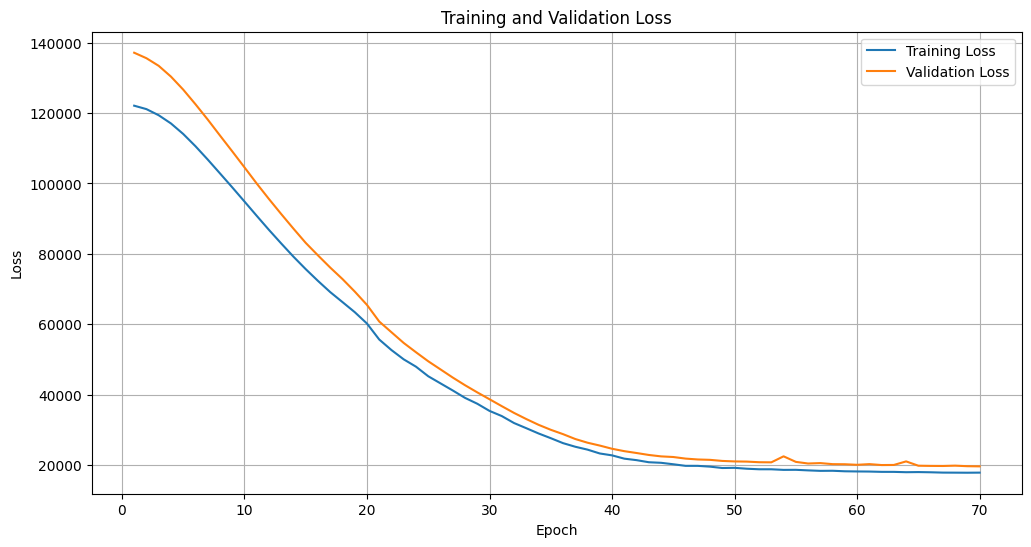

In [21]:
# 1st try, 70 epochs, lr 0.002, d-model 128, N 2
plot_loss(train_loss, val_loss, epochs)

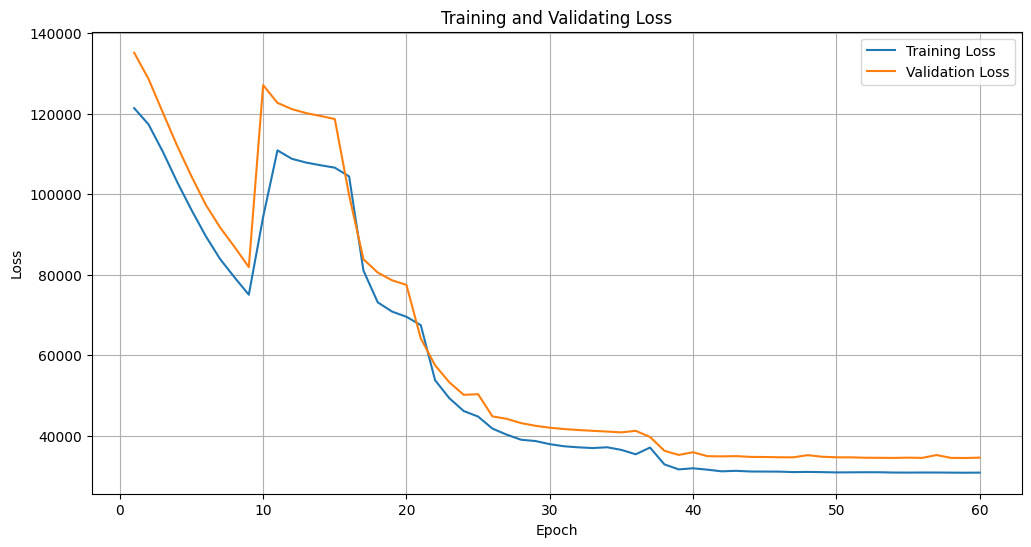

In [25]:
# 2nd try: 60 epochs, lr 0.004, time 37m
plot_loss(train_loss, val_loss, epochs)

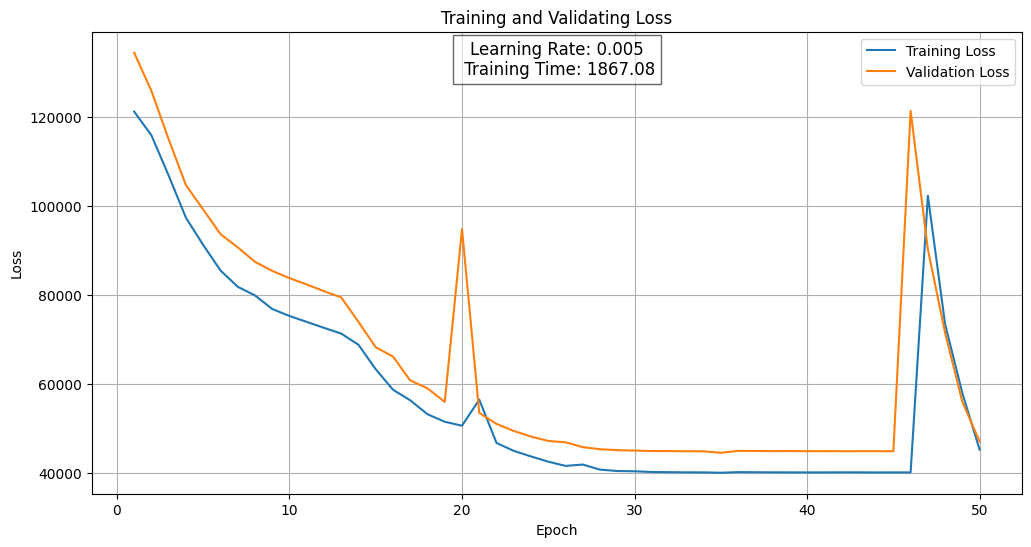

In [37]:
import time
# 3rd try: 50 epochs, lr 0.005, time 
plot_loss(train_loss, val_loss, epochs, learning_rate, train_time)


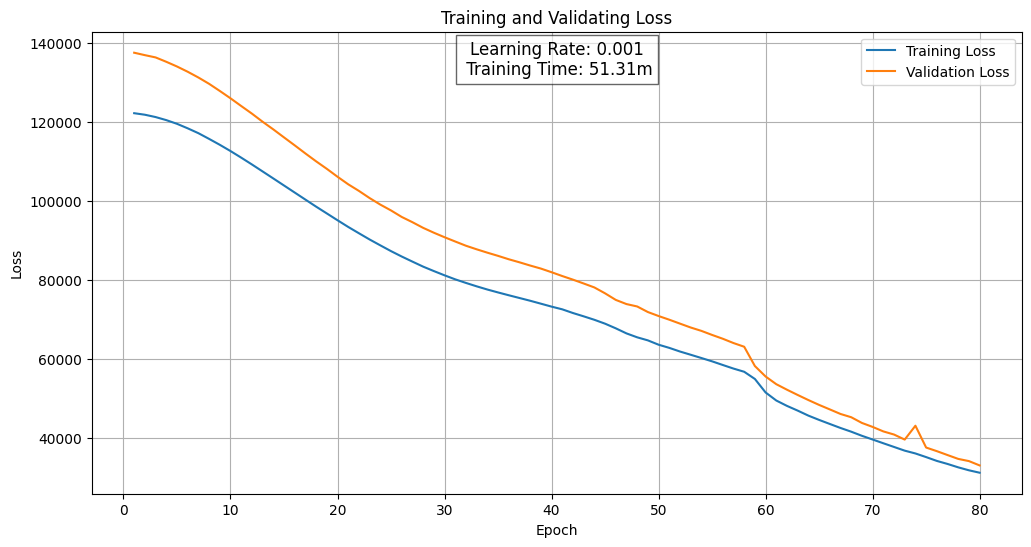

In [41]:

# 4th try: add l2 norm to the last layer of Transformer
plot_loss(train_loss, val_loss, epochs, learning_rate, train_time)

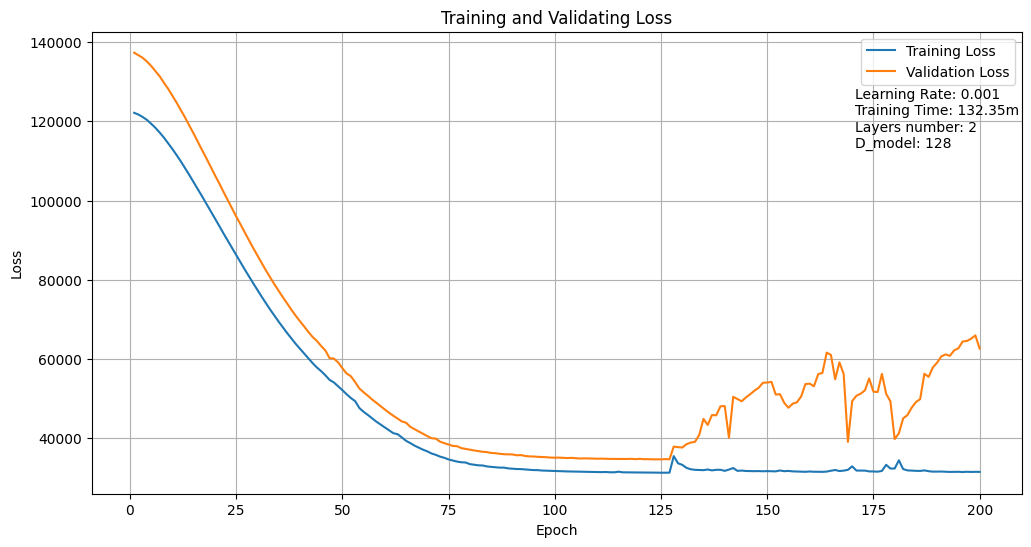

In [82]:
# !pip install plotly
%run tf_helpers.py
# 5th: 
plot_loss(train_loss, val_loss, epochs, learning_rate, train_time, N, d_model)

In [ ]:
# d_model = 512, N = 6, add 1 more l2 to encoder, dropout 0.3
